In [1]:
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from levee_hunter.segmentation_dataset import SegmentationDataset
from levee_hunter.utils import count_parameters
from levee_hunter.plots import infer_and_visualize

In [2]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
print("Number of GPUs:", torch.cuda.device_count())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
cuDNN version: 90100
Number of GPUs: 1
GPU Name: NVIDIA L40S


In [3]:
# Load the datasets
good_dataset = torch.load("../data/intermediate/w1-2-based-datasets/good_dataset_256_nooverlap.pth", weights_only=False)
bad_dataset = torch.load("../data/intermediate/w1-2-based-datasets/bad_dataset_256_nooverlap.pth", weights_only=False)

# Verify the data loaded correctly
print(len(good_dataset))  
print(len(bad_dataset))   

1331
1331


In [4]:
# Removing empty images (where target does not contain levee)
good_dataset.remove_empty(keep_empty=0.2)
bad_dataset.remove_empty(keep_empty=0.0)

In [5]:
len(good_dataset.images), len(bad_dataset.images)

(286, 103)

In [6]:
# Define augmentations
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),  # Random horizontal flip
    A.VerticalFlip(p=0.5),    # Random vertical flip
    A.RandomRotate90(p=0.5),  # Random 90-degree rotation
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),  # Small shifts, scaling, rotation
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),  # Elastic deformation
    A.Normalize(mean=0.0, std=1.0),  # Normalize to 0 mean and 1 std
])

normalize_only = A.Compose([
    A.Normalize(mean=0.0, std=1.0),  # Normalize to 0 mean and 1 std
])

/home/pmucha/.conda/envs/Fathom/lib/python3.11/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_115186/4123746944.py:7: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),  # Elastic deformation


In [7]:
# Set transforms, for training use augmentations, for testing just normalize
good_dataset.transform = train_transform
bad_dataset.transform = normalize_only

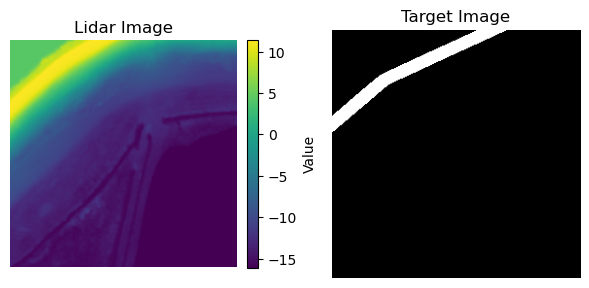

In [8]:
good_dataset.plot(10, transform=False)

The idea is that good_dataset contains images made out of those original (3000, 3000) images which appeared to not have any levees missing.
bad_dataset is made out of those that did have some levees missing.

Then self.remove_empty(keep_empty=0.2) is used to select only those images in dataset which have a target image with levee on it (levee pixels are masked with 0 so if there is 0 anywhere on the target image, this means it has a levee on it). keep_empty is used to then add a fraction of those images which did not have any levee on target image, eg 0.2 means that for 100 non empty images, 20 empty ones are added. This procedure redefines self.images as having mostly non empty images, and some smaller portion of empty images. For good_dataset there is no risk of having levee on Lidar image while having empty target image, because as mentioned earlier good_dataset is made out of those pictures which did not have missing levees. For bad_images this risk is not eliminated so far and that is why this dataset is named bad_dataset. 

The good_dataset is ready to be used for training at this point. Some fraction of it could be used for validation, but I decided to use bad_dataset instead, choosing a few images by eye and checking if they do not have missing levees.

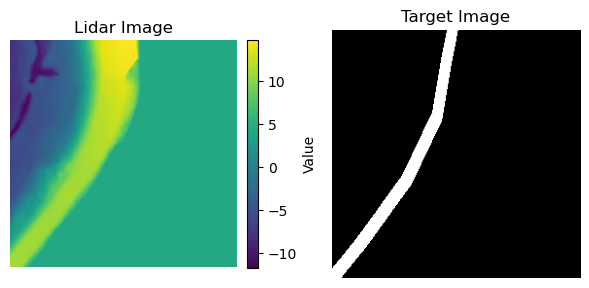

In [9]:
bad_dataset.plot(idx=12)

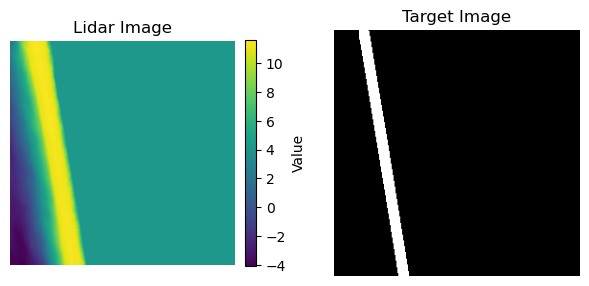

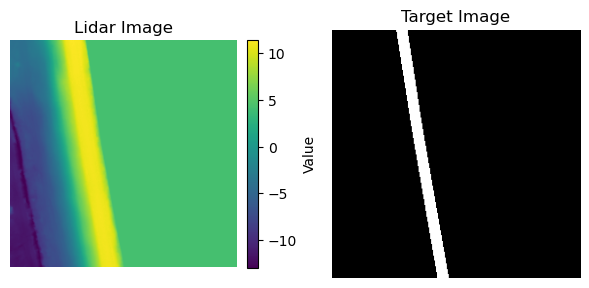

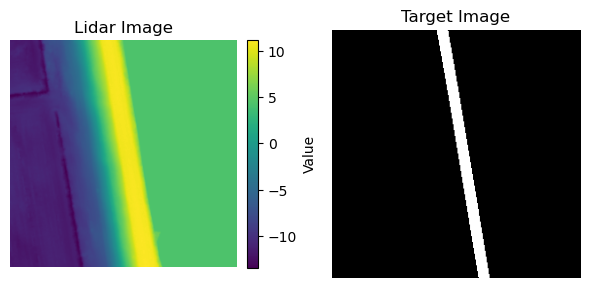

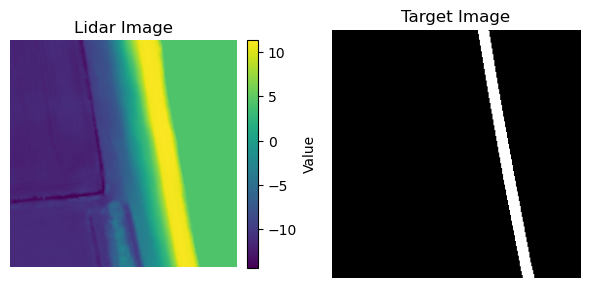

In [10]:
for ix in range(4):
    bad_dataset.plot(ix, transform=False)

In [11]:
# Selected images which are challenging, for by eye validaion only
# Eg three of them have missing levees
by_eye_val_images = np.array(bad_dataset.images)[[49, 53, 85, 4, 11, 26, 52, 58, 70, 79]]
by_eye_val_targets = np.array(bad_dataset.targets)[[49, 53, 85, 4, 11, 26, 52, 58, 70, 79]]
by_eye_val_images.shape

(10, 1, 256, 256)

In [12]:
# Create a dataset
val_by_eye_dataset = SegmentationDataset(
    images=by_eye_val_images, 
    targets=by_eye_val_targets, 
    transform=normalize_only, 
    split=False, 
    patch_size=None, 
    final_size=None, 
    overlap=0
    )

In [13]:
# Remove three images with missing levees
good_for_val_images = np.delete(np.array(bad_dataset.images), [49, 53, 85], axis=0)
good_for_val_targets = np.delete(np.array(bad_dataset.targets), [49, 53, 85], axis=0)
good_for_val_images.shape

(100, 1, 256, 256)

In [14]:
# Now lets take a few empty images and add them to validation dataset
# We take those from the good dataset, so that there is no risk of
# accidentally having a levee on Lidar image and not on target
empty_images = np.array(good_dataset.empty_images)[:20]
empty_targets = np.array(good_dataset.empty_targets)[:20]
empty_images.shape, empty_targets.shape

((20, 1, 256, 256), (20, 1, 256, 256))

In [15]:
val_dataset = SegmentationDataset(images=np.concatenate([good_for_val_images, empty_images]).squeeze(), 
                                  targets=np.concatenate([good_for_val_targets, empty_targets]).squeeze(),
                                  transform = normalize_only, split=False)

In [16]:
val_dataset.images[0].shape

(256, 256)

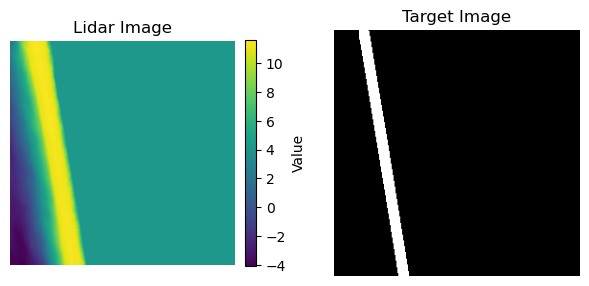

In [17]:
bad_dataset.plot(0)

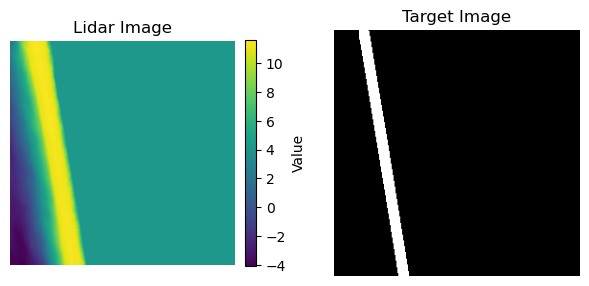

In [18]:
val_dataset.plot(0)

# Data Loader and Batch Size

In [19]:
batch_size = 45
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_loader = DataLoader(good_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

In [20]:
train_loader.dataset.images[0].shape

torch.Size([1, 256, 256])

In [21]:
torch.cuda.is_available()

True

# Model

In [22]:
model = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=1, classes=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [23]:
train_loader.dataset.weights_return=False

In [24]:
device

'cuda'

In [25]:
best_loss = float('inf')
epochs = 35

train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for images, mask in train_loader:
        images, mask = images.to(device), mask.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, mask in val_loader:
            images, mask = images.to(device), mask.to(device)
            output = model(images)
            loss = criterion(output, mask)
            val_loss += loss.item()

    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print(f"Epoch: {epoch+1}/{epochs} Train Loss: {train_loss} Val Loss: {val_loss}")

Epoch: 1/35 Train Loss: 0.607410226549421 Val Loss: 0.723659873008728
Epoch: 2/35 Train Loss: 0.46545927439417156 Val Loss: 0.988233745098114
Epoch: 3/35 Train Loss: 0.4005205248083387 Val Loss: 1.431969404220581
Epoch: 4/35 Train Loss: 0.3717792459896633 Val Loss: 1.9109015464782715
Epoch: 5/35 Train Loss: 0.34750204001154217 Val Loss: 1.7647955417633057
Epoch: 6/35 Train Loss: 0.3293680463518415 Val Loss: 1.887039065361023
Epoch: 7/35 Train Loss: 0.2974002829619816 Val Loss: 1.101357340812683
Epoch: 8/35 Train Loss: 0.2712743878364563 Val Loss: 0.5920040607452393
Epoch: 9/35 Train Loss: 0.2738206258841923 Val Loss: 0.4516439139842987
Epoch: 10/35 Train Loss: 0.2595812976360321 Val Loss: 0.39215847849845886
Epoch: 11/35 Train Loss: 0.24679604598454066 Val Loss: 0.35435718297958374
Epoch: 12/35 Train Loss: 0.21922672433512552 Val Loss: 0.32385504245758057
Epoch: 13/35 Train Loss: 0.2283519889627184 Val Loss: 0.31653618812561035
Epoch: 14/35 Train Loss: 0.21893112361431122 Val Loss: 0.3

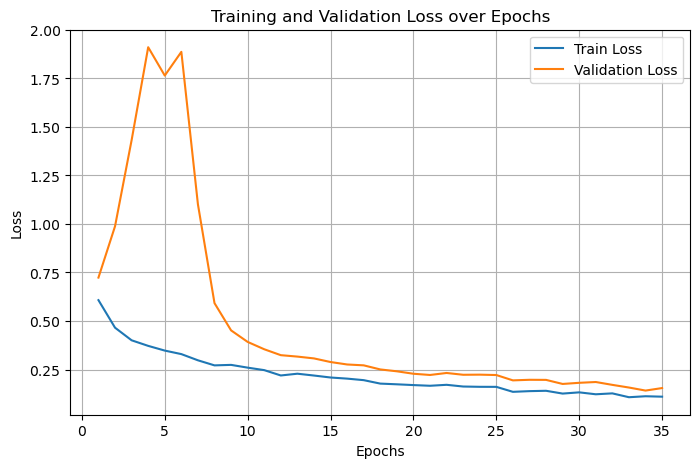

In [26]:
# Plot training and validation loss
epochs_range = range(1, len(train_loss_list) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_loss_list, label="Train Loss")
plt.plot(epochs_range, val_loss_list, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
torch.save(model.state_dict(), "../models/w1-2-based-model/unet-model.pth")

print("Saved model at ../models/w1-2-based-model/unet-model.pth")

Saved model at ../models/w1-2-based-model/unet-model.pth


In [28]:
count_parameters(model)

24430097

0


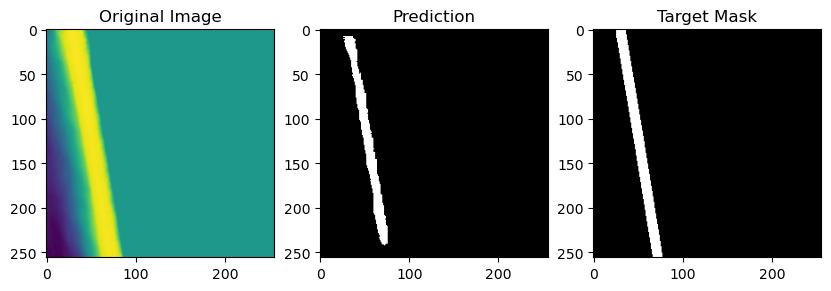

1


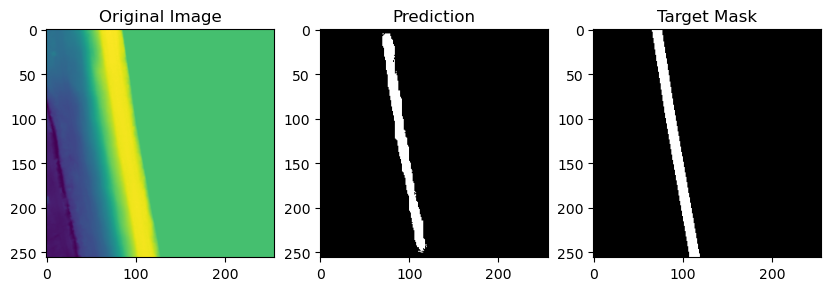

2


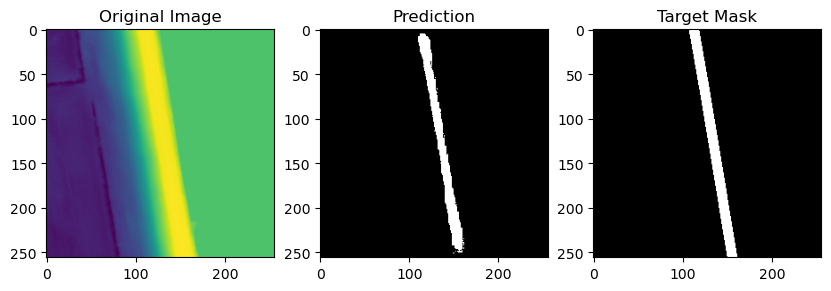

3


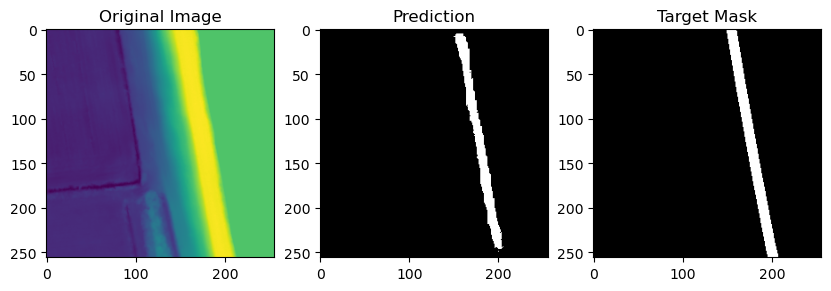

4


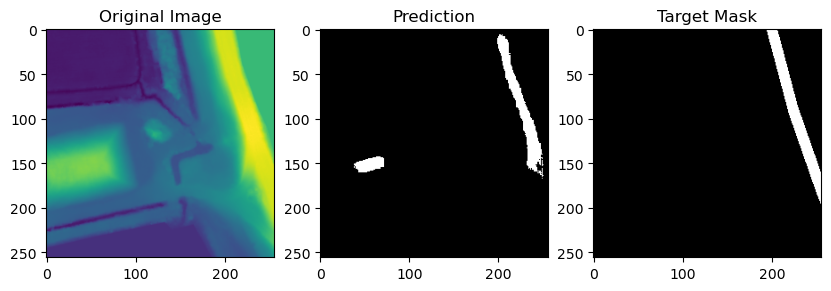

In [29]:
val_dataset.transform = normalize_only
for ix in range(5):
    sample_image, sample_mask = val_dataset[ix]
    print(ix)
    output = infer_and_visualize(model, sample_image, sample_mask, apply_sigmoid=True, device=device)